In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('transaction.csv')

In [4]:
data.head()

,hash,timestamp,fee,from,to,input,output
0,af869b6a322b5d576cd4ae46822b2c857a9feb920d663f...,1673281121,670,32pJhSQvzb4r3vabGYLmXQcChXGrnLjrYB,bc1qtg3rejp0vw7mvkm03wc8fttjteaeqseq8046gm,58822287,58821617
1,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1Bjm2xyKekc3AQgEXQds9ABGJMEKfRoCdS,bc1q9j5fkl6pq8wkhjufzeqmn6zzj92h9lrxpug0t5,1637400,8675055
2,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1Bjm2xyKekc3AQgEXQds9ABGJMEKfRoCdS,1AFgzy1amnxtyX4DtWxigTmF3tikkDYoED,1637400,52635
3,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1DMiRoDeNeyeMG3WpCvAMG3BdaJhN9dqe5,bc1q9j5fkl6pq8wkhjufzeqmn6zzj92h9lrxpug0t5,550448,8675055
4,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1DMiRoDeNeyeMG3WpCvAMG3BdaJhN9dqe5,1AFgzy1amnxtyX4DtWxigTmF3tikkDYoED,550448,52635


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   hash       1000000 non-null  object
 1   timestamp  1000000 non-null  int64 
 2   fee        1000000 non-null  int64 
 3   from       1000000 non-null  object
 4   to         1000000 non-null  object
 5   input      1000000 non-null  int64 
 6   output     1000000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.4+ MB


In [6]:
# null values
data.isnull().sum()

hash         0
timestamp    0
fee          0
from         0
to           0
input        0
output       0
dtype: int64

### Data Preprocessing

In [7]:
#Convert timestamp to date and extract hour 
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
data['hour_of_day'] = data['datetime'].dt.hour

In [8]:
# Calculate the difference between input and output 
data['amount_diff'] = ((data['input'] - data['output'])).abs()
data.head()

,hash,timestamp,fee,from,to,input,output,datetime,hour_of_day,amount_diff
0,af869b6a322b5d576cd4ae46822b2c857a9feb920d663f...,1673281121,670,32pJhSQvzb4r3vabGYLmXQcChXGrnLjrYB,bc1qtg3rejp0vw7mvkm03wc8fttjteaeqseq8046gm,58822287,58821617,2023-01-09 16:18:41,16,670
1,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1Bjm2xyKekc3AQgEXQds9ABGJMEKfRoCdS,bc1q9j5fkl6pq8wkhjufzeqmn6zzj92h9lrxpug0t5,1637400,8675055,2023-01-09 16:18:41,16,7037655
2,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1Bjm2xyKekc3AQgEXQds9ABGJMEKfRoCdS,1AFgzy1amnxtyX4DtWxigTmF3tikkDYoED,1637400,52635,2023-01-09 16:18:41,16,1584765
3,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1DMiRoDeNeyeMG3WpCvAMG3BdaJhN9dqe5,bc1q9j5fkl6pq8wkhjufzeqmn6zzj92h9lrxpug0t5,550448,8675055,2023-01-09 16:18:41,16,8124607
4,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1DMiRoDeNeyeMG3WpCvAMG3BdaJhN9dqe5,1AFgzy1amnxtyX4DtWxigTmF3tikkDYoED,550448,52635,2023-01-09 16:18:41,16,497813


### EDA

Illegal Trading Features

1. 時間特徵:
檢查交易發生的時間（例如：夜間或凌晨）是否與一般交易模式不符。
分析交易發生的頻率和時間點，異常的模式可能表示有違法交易。

2. 交易金額特徵：
評估交易金額是否異常高或低，以及是否有不尋常的差額。
異常的金額差額可能表示有隱藏的費用或不正常的資金轉移。

3. 地址特徵：
檢查是否有特定地址在多筆交易中重複出現，
頻繁出現的地址可能涉及詐騙。

4. 費用(Fee)特徵：
分析交易費用是否顯著高於平均水平。

In [9]:
data.describe()

,timestamp,fee,input,output,hour_of_day,amount_diff
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1000000.000000,1.000000e+06
mean,1.673334e+09,4.986351e+03,3.006627e+08,1.720584e+08,13.911053,2.631032e+08
std,3.274904e+04,1.473165e+04,5.552112e+09,6.934021e+09,6.484819,7.171359e+09
min,1.673281e+09,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1.673302e+09,8.310000e+02,2.589380e+05,1.450130e+05,9.000000,9.157375e+04
50%,1.673338e+09,1.672000e+03,1.328504e+06,8.010310e+05,16.000000,7.557735e+05
75%,1.673363e+09,3.633000e+03,1.043192e+07,4.446455e+06,19.000000,5.592929e+06
max,1.673396e+09,1.763338e+06,1.626698e+12,1.508698e+12,23.000000,1.508698e+12


Text(0, 0.5, 'Times')

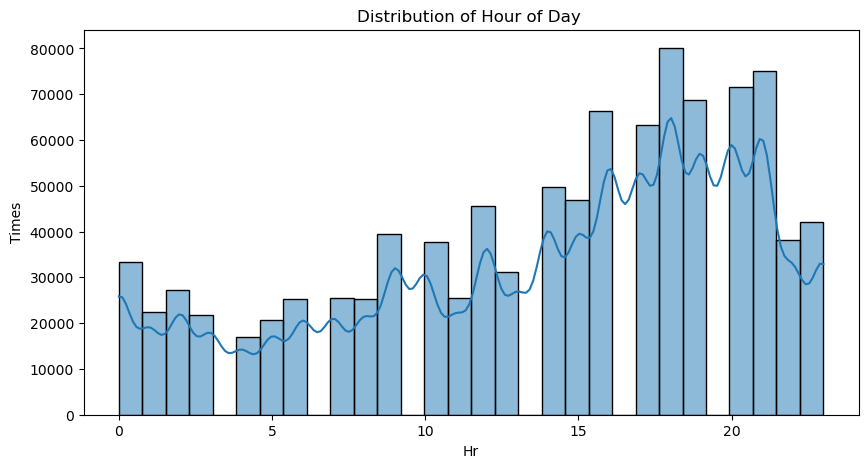

In [10]:
# Distribution of Hour of Day 
plt.figure(figsize=(10, 5))
sns.histplot(data['hour_of_day'], bins=30, kde=True)
plt.title('Distribution of Hour of Day ')
plt.xlabel('Hr')
plt.ylabel('Times')

Text(0.5, 0, 'Transaction Amount')

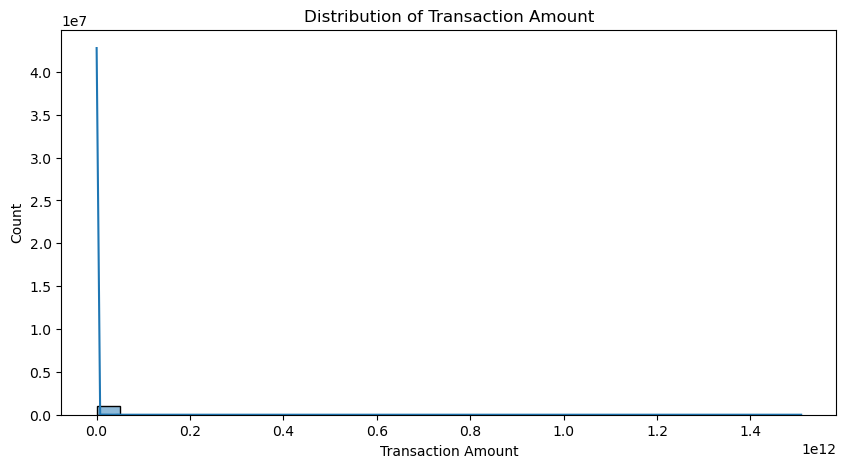

In [11]:
# Distribution of Transaction Amount 
plt.figure(figsize=(10, 5))
sns.histplot(data['amount_diff'], bins=30, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Transaction Amount')

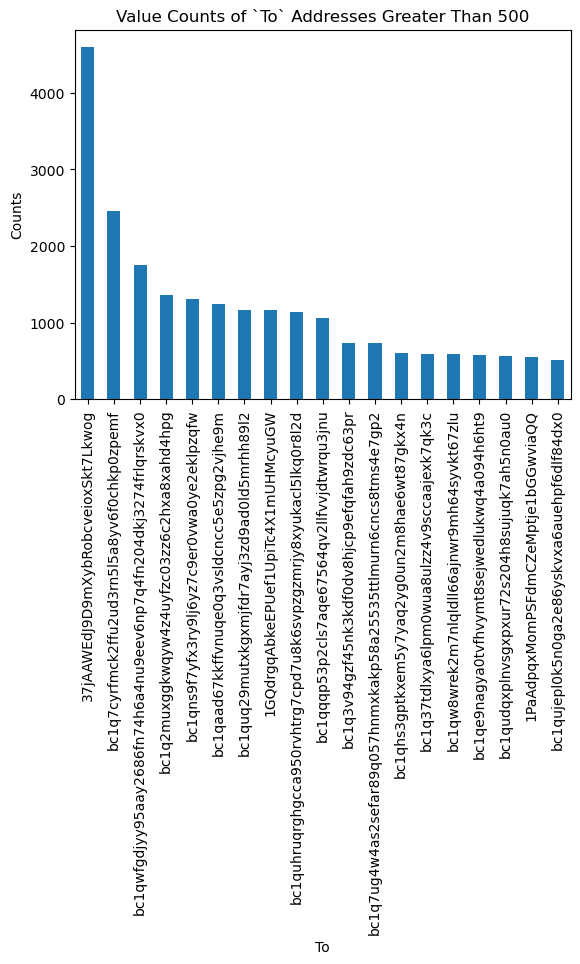

In [12]:
# Distribution of 'to' addresses
value_counts = data['to'].value_counts()

# 出現次數超過 500 次的 addresses
filtered_data = value_counts[value_counts > 500]

filtered_data.plot(kind='bar') 
plt.xlabel('To')
plt.ylabel('Counts')
plt.title('Value Counts of `To` Addresses Greater Than 500')
plt.show()

Text(0.5, 0, 'Fee')

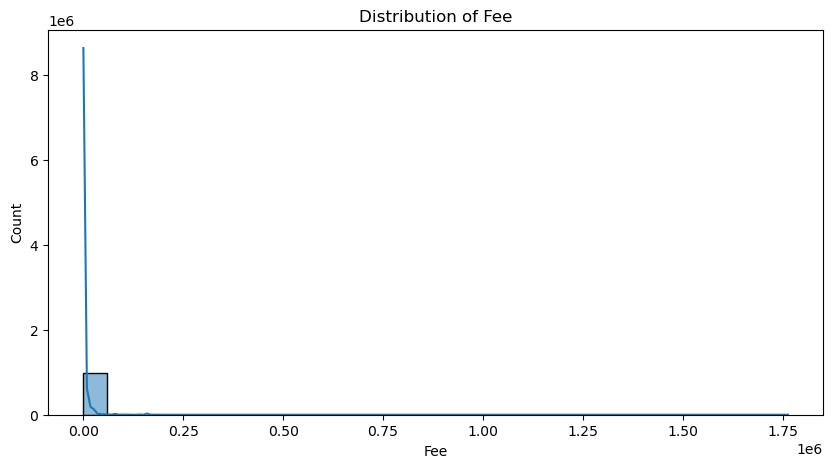

In [13]:
# Distribution of Fee 
plt.figure(figsize=(10, 5))
sns.histplot(data['fee'], bins=30, kde=True)
plt.title('Distribution of Fee')
plt.xlabel('Fee')

### Illegal Trading Detection

In [14]:
high_fee_threshold = data['fee'].mean() + 3 * data['fee'].std()
high_amount_diff_threshold = data['amount_diff'].mean() + 3 * data['amount_diff'].std()
unusual_hour_start = 0
unusual_hour_end = 6


#猜測 case1: fee (手續費) 過大 較可能為異常交易
data['is_fraud_fee'] = data['fee'] > high_fee_threshold 

#猜測 case2: input和 output差值(金額差值)過大 較可能為異常交易
data['is_fraud_amount'] = data['amount_diff'] > high_amount_diff_threshold

#猜測 case3: 不正常交易時間(0-6 AM) 較可能為異常交易
data['is_fraud_UnusualHr'] = (data['hour_of_day'] >= unusual_hour_start) & (data['hour_of_day'] <= unusual_hour_end)

#猜測 case4: input和output差值(金額差值)過大 且 在不正常交易時間(0-6 AM) 較可能為異常交易
data['is_fraud_amount_UnusualHr'] = (data['amount_diff'] > high_amount_diff_threshold) & ((data['hour_of_day'] >= unusual_hour_start) & (data['hour_of_day'] <= unusual_hour_end))


# Count of transactions
fraud_count_fee       = data['is_fraud_fee'].sum()
fraud_count_amount    = data['is_fraud_amount'].sum()
fraud_count_UnusualHr = data['is_fraud_UnusualHr'].sum()
fraud_count_amount_UnusualHr = data['is_fraud_amount_UnusualHr'].sum()

print(f'=========case1: 根據fee_被標記為可能非法交易行為的交易數量: {fraud_count_fee}=========')   
print(data[data['is_fraud_fee'] == 1].head(10))
print(f'=========case2: 根據amount_被標記為可能非法交易行為的交易數量: {fraud_count_amount}=========') 
print(data[data['is_fraud_amount'] == 1].head(10))
print(f'=========case3: 根據UnusualHr_被標記為可能非法交易行為的交易數量: {fraud_count_UnusualHr}=========') 
print(data[data['is_fraud_UnusualHr'] == 1].head(10))
print(f'=========case4: 根據amount_UnusualHr_被標記為可能非法交易行為的交易數量: {fraud_count_amount_UnusualHr}=========') 
print(data[data['is_fraud_amount_UnusualHr'] == 1].head(10))


=========case1: 根據fee_被標記為可能非法交易行為的交易數量: 12788=========
                                                  hash   timestamp    fee  \
169  da1babf746093445f7b1467e7dfd2c9ff4011d3bbd1679...  1673281121  56699   
170  da1babf746093445f7b1467e7dfd2c9ff4011d3bbd1679...  1673281121  56699   
171  da1babf746093445f7b1467e7dfd2c9ff4011d3bbd1679...  1673281121  56699   
191  b4b20eb44258d7bf65e79747c1ab5faed8634df28eb107...  1673281121  56416   
192  b4b20eb44258d7bf65e79747c1ab5faed8634df28eb107...  1673281121  56416   
193  b4b20eb44258d7bf65e79747c1ab5faed8634df28eb107...  1673281121  56416   
194  b4b20eb44258d7bf65e79747c1ab5faed8634df28eb107...  1673281121  56416   
199  cb9bced822b08264027ffec5f50e099370d2dd0a1a3fc6...  1673281121  75786   
200  cb9bced822b08264027ffec5f50e099370d2dd0a1a3fc6...  1673281121  75786   
201  cb9bced822b08264027ffec5f50e099370d2dd0a1a3fc6...  1673281121  75786   

                                   from  \
169  1KMhuXgUsTy2XW1xDyeKGEPYQtcYpht3JJ   
170  1KMhu

In [15]:
data.head()

,hash,timestamp,fee,from,to,input,output,datetime,hour_of_day,amount_diff,is_fraud_fee,is_fraud_amount,is_fraud_UnusualHr,is_fraud_amount_UnusualHr
0,af869b6a322b5d576cd4ae46822b2c857a9feb920d663f...,1673281121,670,32pJhSQvzb4r3vabGYLmXQcChXGrnLjrYB,bc1qtg3rejp0vw7mvkm03wc8fttjteaeqseq8046gm,58822287,58821617,2023-01-09 16:18:41,16,670,False,False,False,False
1,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1Bjm2xyKekc3AQgEXQds9ABGJMEKfRoCdS,bc1q9j5fkl6pq8wkhjufzeqmn6zzj92h9lrxpug0t5,1637400,8675055,2023-01-09 16:18:41,16,7037655,False,False,False,False
2,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1Bjm2xyKekc3AQgEXQds9ABGJMEKfRoCdS,1AFgzy1amnxtyX4DtWxigTmF3tikkDYoED,1637400,52635,2023-01-09 16:18:41,16,1584765,False,False,False,False
3,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1DMiRoDeNeyeMG3WpCvAMG3BdaJhN9dqe5,bc1q9j5fkl6pq8wkhjufzeqmn6zzj92h9lrxpug0t5,550448,8675055,2023-01-09 16:18:41,16,8124607,False,False,False,False
4,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1DMiRoDeNeyeMG3WpCvAMG3BdaJhN9dqe5,1AFgzy1amnxtyX4DtWxigTmF3tikkDYoED,550448,52635,2023-01-09 16:18:41,16,497813,False,False,False,False


In [16]:
#猜想 case5: fee頻繁資金轉移的帳戶(to): 平均金額最高  較可能為異常交易
#猜想 case6: fee頻繁資金轉移的帳戶(to)  其總金額     較可能為異常交易

avg_fee_diff_per_to = data.groupby('to')['fee'].mean()
avg_fee_diff_per_to

# 計算個別to帳戶出現的次數
to_counts = data['to'].value_counts()
to_counts

result = pd.DataFrame({
    'fee_diff_mean': avg_fee_diff_per_to,
    'count': to_counts,
    'total_amount':avg_fee_diff_per_to*to_counts
})

result

,fee_diff_mean,count,total_amount
111tSC83mdvaMBFgAa9qAZQPChZyaGenW,678.0,1,678.0
1121oXaoMsZ2tMRn7587YZsiN8FfVJqJWU,980.0,1,980.0
1122exqo82mAVc5X4rzuSHJ49QodYWxpzV,45630.0,2,91260.0
1122wSwVSThvBtQZPwPpvEADiqxwqkw1MG,6102.0,1,6102.0
11234MYmtxG6CmHg5bmF6BqBu1pxXvGvPu,1122.0,1,1122.0
...,...,...,...
nonstandardffbc756ee4e49ea6267c6dde3aaf7d126d4ffafe,182.0,1,182.0
nonstandardffe644d67479a52953c6c0adf5265916bdcc8416,550.0,1,550.0
nonstandardffe9b21f69f32a6a5f0ff03e86884a8bc2be0d7e,264.0,1,264.0
nonstandardfff353d637539d2b07192b798a0f8fcf0d4cdf75,4895.0,1,4895.0


In [17]:
#case5: 排序前10名金額平均最多的帳戶(to)
top_10_fee_diff_mean = result.sort_values(by='fee_diff_mean', ascending=False).head(10)
print('case5:fee 流向(to)平均金額最高的前10個帳戶\n')
print(top_10_fee_diff_mean)  
print('\n\n')

#case6: 排序前10名金額最多的帳戶(to)
top_10_fee_diff_total = result.sort_values(by='total_amount', ascending=False).head(10)
print('case6:fee 流向(to)其總金額最高的前10個帳戶\n')
print(top_10_fee_diff_total)


case5:fee 流向(to)平均金額最高的前10個帳戶

                                            fee_diff_mean  count  total_amount
39Mftf31ke5jmcS76QVE2sR8K93VfzsaPb           1.763338e+06      1     1763338.0
3QFuaabfUBRVTuarBBNAvT1m15PTw3aXx3           1.262096e+06      1     1262096.0
bc1qd8jv4p06l7jpvrjlztxsu6d6udntzv586fml0k   1.262096e+06      1     1262096.0
bc1qj0t2adswwsgeycu6qqh0paz5j5da25wl4x9peh   7.100000e+05      1      710000.0
bc1q573cv3s4vfd0krteymuylq42m6hljc4w4t7w4l   7.100000e+05      1      710000.0
bc1qrnemww0ulk32f7ydtj7cd40j30cf3cndd5cwkn   6.285273e+05     11     6913800.0
3MHCzrUb1kioyYy65zibazBEuER4VWKYCL           5.733231e+05     13     7453200.0
bc1qapujp77nj4u6hhsftneun6luk4kzvzcl32v9xy   5.557400e+05      1      555740.0
bc1qf0xt5fenvw6rsujntmfkvn0pczjmqlvv33ajvg   5.557400e+05      1      555740.0
bc1q0ayfkx7mgwqum7e487tfpne4dxmucuvm9wn5w0   4.498000e+05      4     1799200.0



case6:fee 流向(to)其總金額最高的前10個帳戶

                                                    fee_diff_mean 

### kmeans方式 - 監測異常交易

想法: 簡單以兩個特徵為例 (較好示意)
使用kmeans方式,設定一個cluster中心(分一個群)
大部分的資料為正常的一群,
而離cluster中心距離較遠的資料則判定為異常值(離群值,假定為不合法交易)

離群值數量這邊會抓0.01%的總資料量(作為示意)

In [18]:
data.head()

,hash,timestamp,fee,from,to,input,output,datetime,hour_of_day,amount_diff,is_fraud_fee,is_fraud_amount,is_fraud_UnusualHr,is_fraud_amount_UnusualHr
0,af869b6a322b5d576cd4ae46822b2c857a9feb920d663f...,1673281121,670,32pJhSQvzb4r3vabGYLmXQcChXGrnLjrYB,bc1qtg3rejp0vw7mvkm03wc8fttjteaeqseq8046gm,58822287,58821617,2023-01-09 16:18:41,16,670,False,False,False,False
1,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1Bjm2xyKekc3AQgEXQds9ABGJMEKfRoCdS,bc1q9j5fkl6pq8wkhjufzeqmn6zzj92h9lrxpug0t5,1637400,8675055,2023-01-09 16:18:41,16,7037655,False,False,False,False
2,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1Bjm2xyKekc3AQgEXQds9ABGJMEKfRoCdS,1AFgzy1amnxtyX4DtWxigTmF3tikkDYoED,1637400,52635,2023-01-09 16:18:41,16,1584765,False,False,False,False
3,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1DMiRoDeNeyeMG3WpCvAMG3BdaJhN9dqe5,bc1q9j5fkl6pq8wkhjufzeqmn6zzj92h9lrxpug0t5,550448,8675055,2023-01-09 16:18:41,16,8124607,False,False,False,False
4,5611b6886e1eb77a0fc19c8eb83a793338c44060efe926...,1673281121,4090,1DMiRoDeNeyeMG3WpCvAMG3BdaJhN9dqe5,1AFgzy1amnxtyX4DtWxigTmF3tikkDYoED,550448,52635,2023-01-09 16:18:41,16,497813,False,False,False,False


C:\Users\Tiffany\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


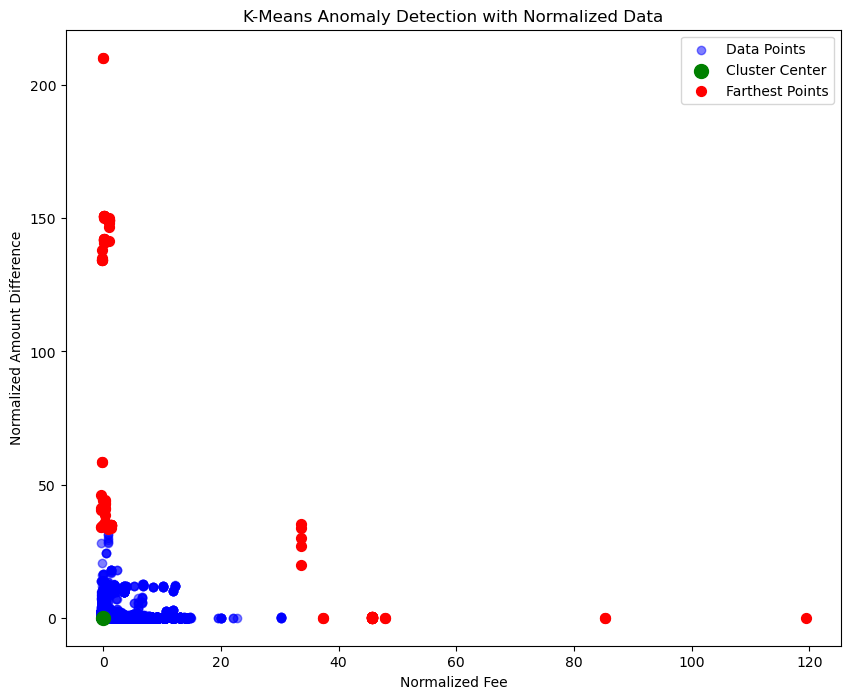

In [19]:
#選擇'fee', 'amount_diff' 當作kmeans的分群標準 (此處選兩個維度並畫圖示意)
select_feature = data[['fee', 'amount_diff']]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(select_feature)

# Performing KMeans clustering, n_clusters=1 (one cluster center)
kmeans = KMeans(n_clusters=1, random_state=0)
kmeans.fit(data_scaled)

#cluster center
cluster_center = kmeans.cluster_centers_

#Distance from each point to the cluster center
distances = np.linalg.norm(data_scaled - cluster_center, axis=1)

#The 100 farthest points
farthest_100 = np.argsort(distances)[-100:]

# Plotting all points, cluster center, and the 100 farthest points
plt.figure(figsize=(10, 8))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c='blue', label='Data Points', alpha=0.5)
plt.scatter(cluster_center[:, 0], cluster_center[:, 1], c='g', label='Cluster Center', s=100)
plt.scatter(data_scaled[farthest_100, 0], data_scaled[farthest_100, 1], c='r', label='Farthest Points', s=50)
plt.title('K-Means Anomaly Detection with Normalized Data')
plt.legend()
plt.xlabel('Normalized Fee')
plt.ylabel('Normalized Amount Difference')
plt.show()

這些被標記的交易('Farthest Points')可以進一步調查，以確認它們是否真的是詐欺行為。

**如果經過證實，確定為非法行為，label完後，未來即可針對此 label 去做 Supervised Learning.